In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sodapy import Socrata

"""
This notebook is designed to develop the relationship between mortality data due to cardiovascular desease
and defibrilator placements (medical and non-medical). Of course, AED will be used before death, but this data
could account for potential areas that have a higher degree of mortality due to cardiovascular desease. 
Analysis will be done considering comarcal geographical distributions, which is the highest resolution data
we have related to mortality rates.
Of course, AEDs can be used in other medical related deseases, but we will specially focus on cardiovascular 
due to the direct relationship.
"""



"""
The first step is to load the available data into the df and clean it. In dades.ipnyb the mortality data, 
defibrillator and hospital data was cleaned.
"""
client = Socrata("analisi.transparenciacatalunya.cat", None)
desfibriladors = client.get_all("wpud-ukyg")
hospitals = client.get_all("8gmd-gz7i")
df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_hospitals = pd.DataFrame.from_records(hospitals)

df_hospitals = df_hospitals[df_hospitals["categoria"].str.contains(r"Salut\|Centres", na=False)]
df_hospitals = df_hospitals.drop_duplicates(subset='idequipament', keep='first')


df_desfibriladors = df_desfibriladors.drop_duplicates(subset='numero_serie', keep='first')


url = "https://www.idescat.cat/serveis/consultes/ca/censph_10_mun_2024.csv"
df_cens = pd.read_csv(url, sep=";", encoding="utf-8")


df_mortality = pd.read_csv("mortality.csv", sep=",", encoding="utf-8-sig")



/var/folders/_r/lv31y_xx5hzfyhbw22ddz7gr0000gn/T/ipykernel_63455/1441249014.py:36: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens = pd.read_csv(url, sep=";", encoding="utf-8")


In [2]:
data_dir = "../carto/"

municipis = gpd.read_file(data_dir + "municipis.json")


In [3]:
"""
Now we want to count how many hospitals/AED we have per comarca, and create a df that contains these values
and merge it inot a gpd to have the correct idea.
We also add a column with the mortality per 1000 inh for men/women/total due to cardivascular desease
for each of the comarques.
"""

df_hospi = df_hospitals[['codi_municipi']]
df_desfi = df_desfibriladors[['codi_municipi']]

defi_count = df_desfi.groupby('codi_municipi').size().reset_index(name='num_defi')
hospi_count = df_hospi.groupby('codi_municipi').size().reset_index(name='num_hospi')

hospi_count


,codi_municipi,num_hospi
0,170059,1
1,170062,1
2,170097,1
3,170123,1
4,170139,1
...,...,...
484,83054,7
485,83073,9
486,89024,1
487,89030,1


In [4]:
municipis = municipis.rename(columns={'CODIMUNI': 'codi_municipi', 'NOMMUNI':'municipi', 'NOMCOMAR': 'comarca'})
municipis = municipis[['codi_municipi', 'municipi', 'comarca', 'geometry']]
municipis

,codi_municipi,municipi,comarca,geometry
0,080018,Abrera,Baix Llobregat,"MULTIPOLYGON (((1.92486 41.53663, 1.92197 41.5..."
1,080023,Aguilar de Segarra,Bages,"MULTIPOLYGON (((1.6085 41.76999, 1.60801 41.77..."
2,080039,Alella,Maresme,"MULTIPOLYGON (((2.28512 41.51534, 2.28501 41.5..."
3,080044,Alpens,Lluçanès,"MULTIPOLYGON (((2.09358 42.14245, 2.09225 42.1..."
4,080057,l'Ametlla del Vallès,Vallès Oriental,"MULTIPOLYGON (((2.24126 41.70273, 2.24178 41.7..."
...,...,...,...,...
942,439039,Camarles,Baix Ebre,"MULTIPOLYGON (((0.64239 40.82154, 0.64239 40.8..."
943,439044,l'Aldea,Baix Ebre,"MULTIPOLYGON (((0.60964 40.80699, 0.60855 40.8..."
944,439057,Salou,Tarragonès,"MULTIPOLYGON (((1.13541 41.10119, 1.13523 41.1..."
945,439060,l'Ampolla,Baix Ebre,"MULTIPOLYGON (((0.69184 40.85044, 0.69102 40.8..."


In [5]:
import unicodedata

def normalize(text):
    if isinstance(text, str):
        text = text.lower().strip()
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        text = text.replace('-', ' ').replace("'", "").replace("’", "")
        return text
    return text

In [6]:
"""
Normalise municipal data to make sure all have the same codes
"""

municipis['codi_municipi'] = municipis['codi_municipi'].astype(str).apply(
    lambda x: x[:-1] if len(x) == 6 else x
)
defi_count['codi_municipi'] = defi_count['codi_municipi'].astype(str).apply(
    lambda x: x[:-1] if len(x) == 6 else x
)
def fix_code(x):
    x = str(x)  # ensure string
    # Add leading zero if first digit is 8 and length < 6
    if x.startswith('8') and len(x) < 6:
        x = '0' + x
    # Truncate last digit if length is 6
    if len(x) == 6:
        x = x[:-1]
    return x

hospi_count['codi_municipi'] = hospi_count['codi_municipi'].apply(fix_code)

# Filter rows where edat == "total"
df_cens_total = df_cens[(df_cens["edat"] == "total") & (df_cens["sexe"] == "total")].copy()
df_cens_total = df_cens_total[df_cens_total["valor"] <= 5000000]
df_cens_total = df_cens_total.reset_index(drop=True)
df_cens_total = df_cens_total.rename(columns={"valor": "pob"})

# Keep only geo name and population
df_cens_pop = df_cens_total[["geo", "pob"]].copy()

df_cens_pop = df_cens_pop.rename(columns={'geo': 'codi_municipi'})
df_cens_pop['codi_municipi'] = df_cens_pop['codi_municipi'].apply(fix_code)



In [7]:
import numpy as np
"""
After all the data cleaning, we finally got to where we want to be, a data set that has municipi and comarca and the amount of
defibrillators and medical centers in each of these places.
"""

total = municipis.merge(defi_count, on='codi_municipi', how='left')
total = total.merge(hospi_count, on='codi_municipi', how='left')
total = total.merge(df_cens_pop, on='codi_municipi', how='left')

total = total.fillna(0)
total = total.replace([np.inf, -np.inf], 0)

total


,codi_municipi,municipi,comarca,geometry,num_defi,num_hospi,pob
0,08001,Abrera,Baix Llobregat,"MULTIPOLYGON (((1.92486 41.53663, 1.92197 41.5...",43.0,2.0,12981
1,08002,Aguilar de Segarra,Bages,"MULTIPOLYGON (((1.6085 41.76999, 1.60801 41.77...",0.0,1.0,291
2,08003,Alella,Maresme,"MULTIPOLYGON (((2.28512 41.51534, 2.28501 41.5...",13.0,2.0,10200
3,08004,Alpens,Lluçanès,"MULTIPOLYGON (((2.09358 42.14245, 2.09225 42.1...",1.0,0.0,270
4,08005,l'Ametlla del Vallès,Vallès Oriental,"MULTIPOLYGON (((2.24126 41.70273, 2.24178 41.7...",15.0,0.0,9448
...,...,...,...,...,...,...,...
942,43903,Camarles,Baix Ebre,"MULTIPOLYGON (((0.64239 40.82154, 0.64239 40.8...",2.0,1.0,3428
943,43904,l'Aldea,Baix Ebre,"MULTIPOLYGON (((0.60964 40.80699, 0.60855 40.8...",7.0,1.0,4554
944,43905,Salou,Tarragonès,"MULTIPOLYGON (((1.13541 41.10119, 1.13523 41.1...",43.0,3.0,30442
945,43906,l'Ampolla,Baix Ebre,"MULTIPOLYGON (((0.69184 40.85044, 0.69102 40.8...",12.0,1.0,3692


In [52]:
"""
Now comes the cleaning and doing with the medical data.
"""
df_cardio = df_mortality[df_mortality['Cause'].str.contains('Tot', case=False, na=False)]

sexes = ["Total", "Dones", "Homes"]

dfs = {}
for name in sexes:
    df = (df_cardio[df_cardio['Sexe'] == name]
          .drop(columns=["Sexe", "Cause"])
          .rename(columns={'Comarca':'comarca'})
          .reset_index(drop=True))
    df['comarca'] = df['comarca'].replace({'ARAN': "VAL DARAN"})
    df['comarca'] = df['comarca'].apply(normalize)
    dfs[name] = df

mortality_totals = dfs["Total"]
mortality_women  = dfs["Dones"]
mortality_men    = dfs["Homes"]
    
comarca_totals = total.groupby('comarca')[['num_defi', 'num_hospi', 'pob']].sum().reset_index()

mortality_women

,comarca,< 1,1-4,5-14,15-24,25-34,35-44,45-54,55-64,65-74,...,5-14 rel,15-24 rel,25-34 rel,35-44 rel,45-54 rel,55-64 rel,65-74 rel,75-84 rel,>84 rel,Total rel
0,alt camp,0,0,0,0,0,2,6,21,17,...,0.00,0.00,0.00,65.10,171.09,650.96,726.81,2645.82,12527.23,903.52
1,alt emporda,1,0,0,1,0,5,23,40,54,...,0.00,12.74,0.00,48.02,203.27,408.25,718.95,2084.16,10654.33,733.58
2,alt penedes,0,0,1,0,5,2,8,28,36,...,16.15,0.00,88.57,25.56,83.96,375.99,639.55,2418.28,11507.75,734.63
3,alt urgell,0,0,0,0,0,0,2,4,13,...,0.00,0.00,0.00,0.00,120.70,254.45,1151.46,1368.16,12456.14,972.09
4,alta ribagorca,0,0,0,0,0,0,0,0,1,...,0.00,0.00,0.00,0.00,0.00,0.00,518.13,2459.02,18085.11,1089.21
5,anoia,2,1,1,0,3,4,12,23,47,...,14.80,0.00,46.54,46.23,115.85,280.69,732.32,2357.84,12303.35,790.65
6,bages,1,0,1,0,3,5,15,44,73,...,10.51,0.00,31.82,39.83,103.98,354.87,739.84,2651.19,12836.94,977.62
7,baix camp,2,1,1,1,6,12,24,51,93,...,9.14,8.80,54.78,83.10,145.30,373.57,877.36,2556.48,13311.42,825.22
8,baix ebre,1,0,1,0,0,2,14,22,38,...,25.68,0.00,0.00,37.16,232.29,394.05,830.42,2381.66,12463.20,1023.42
9,baix emporda,3,0,0,0,0,7,10,36,51,...,0.00,0.00,0.00,72.80,88.72,353.32,640.30,2326.49,13366.69,841.74


In [53]:
comarca_totals['comarca'] = comarca_totals['comarca'].apply(normalize)
comarca_totals = comarca_totals[comarca_totals['comarca'] != 'llucanes'].copy()


mortality_dfs = {
    "total": mortality_totals,
    "women": mortality_women,
    "men": mortality_men
}

df_comarques = {}

for key, df_mort in mortality_dfs.items():
    df_comarques[key] = comarca_totals.merge(
        df_mort,
        on='comarca',
        how='left'
    )
    
df_comarques_total = df_comarques["total"]
df_comarques_women = df_comarques["women"]
df_comarques_men   = df_comarques["men"]


In [54]:
"""
We read comarques geopandas and merge it with total
"""
comarques = gpd.read_file(data_dir + "comarca.json")

comarques = comarques[["NOMCOMAR","geometry"]].rename(columns={"NOMCOMAR":"comarca"})
comarques['comarca'] = comarques['comarca'].apply(normalize)

df_mort_com = {}

for key, df_com in df_comarques.items():
    merged = comarques.merge(
        df_com,
        on='comarca',
        how='left'
    )
    merged = gpd.GeoDataFrame(merged, geometry='geometry')

    # Fill missing values
    merged = merged.fillna(0)

    df_mort_com[key] = merged

df_mort_com_total = df_mort_com["total"]
df_mort_com_women = df_mort_com["women"]
df_mort_com_men   = df_mort_com["men"]

df_mort_com_total

,comarca,geometry,num_defi,num_hospi,pob,< 1,1-4,5-14,15-24,25-34,...,5-14 rel,15-24 rel,25-34 rel,35-44 rel,45-54 rel,55-64 rel,65-74 rel,75-84 rel,>84 rel,Total rel
0,alt camp,"MULTIPOLYGON (((1.47594 41.47798, 1.47459 41.4...",64.0,16.0,46388.0,0.0,0.0,0.0,2.0,1.0,...,0.00,38.83,20.36,62.45,214.33,656.89,1285.62,3356.37,13396.09,893.71
1,alt emporda,"MULTIPOLYGON (((3.17533 42.11147, 3.17536 42.1...",283.0,44.0,148732.0,3.0,0.0,1.0,6.0,4.0,...,6.31,36.74,23.80,66.77,225.13,570.16,1199.45,3326.83,11683.08,811.06
2,alt penedes,"MULTIPOLYGON (((1.63329 41.50721, 1.63315 41.5...",236.0,23.0,114189.0,2.0,1.0,2.0,0.0,10.0,...,15.64,0.00,87.54,57.59,145.93,442.68,1263.14,3378.28,12654.70,788.62
3,alt urgell,"MULTIPOLYGON (((1.31941 41.99157, 1.31775 41.9...",53.0,17.0,21128.0,0.0,0.0,0.0,1.0,0.0,...,0.00,47.44,0.00,0.00,120.16,672.43,1337.36,2894.56,14221.22,1077.12
4,alta ribagorca,"MULTIPOLYGON (((0.88075 42.63108, 0.88052 42.6...",15.0,5.0,4040.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,136.05,335.01,1204.82,2690.58,12790.70,893.30
5,anoia,"MULTIPOLYGON (((1.43708 41.8012, 1.4355 41.801...",441.0,17.0,128432.0,3.0,1.0,2.0,3.0,7.0,...,14.32,19.97,52.05,73.14,164.43,608.40,1229.44,3004.51,13136.94,818.87
6,bages,"MULTIPOLYGON (((2.00146 41.96643, 1.99983 41.9...",258.0,34.0,185352.0,2.0,1.0,2.0,4.0,13.0,...,10.15,19.65,67.66,71.83,179.82,592.24,1234.05,3336.07,13721.14,982.04
7,baix camp,"MULTIPOLYGON (((1.03706 41.0577, 1.03707 41.05...",211.0,26.0,204458.0,6.0,2.0,3.0,4.0,14.0,...,13.18,17.00,63.99,84.77,187.54,565.27,1328.11,3463.96,13564.21,840.60
8,baix ebre,"MULTIPOLYGON (((0.77083 40.76315, 0.77095 40.7...",134.0,21.0,82399.0,3.0,0.0,3.0,4.0,2.0,...,37.23,46.22,23.47,62.60,218.36,537.20,1104.97,3403.77,13358.42,1029.01
9,baix emporda,"MULTIPOLYGON (((2.97554 41.75367, 2.97555 41.7...",232.0,31.0,143443.0,6.0,0.0,0.0,2.0,3.0,...,0.00,13.24,19.85,72.82,77.58,493.62,1034.13,3301.84,14804.40,875.74


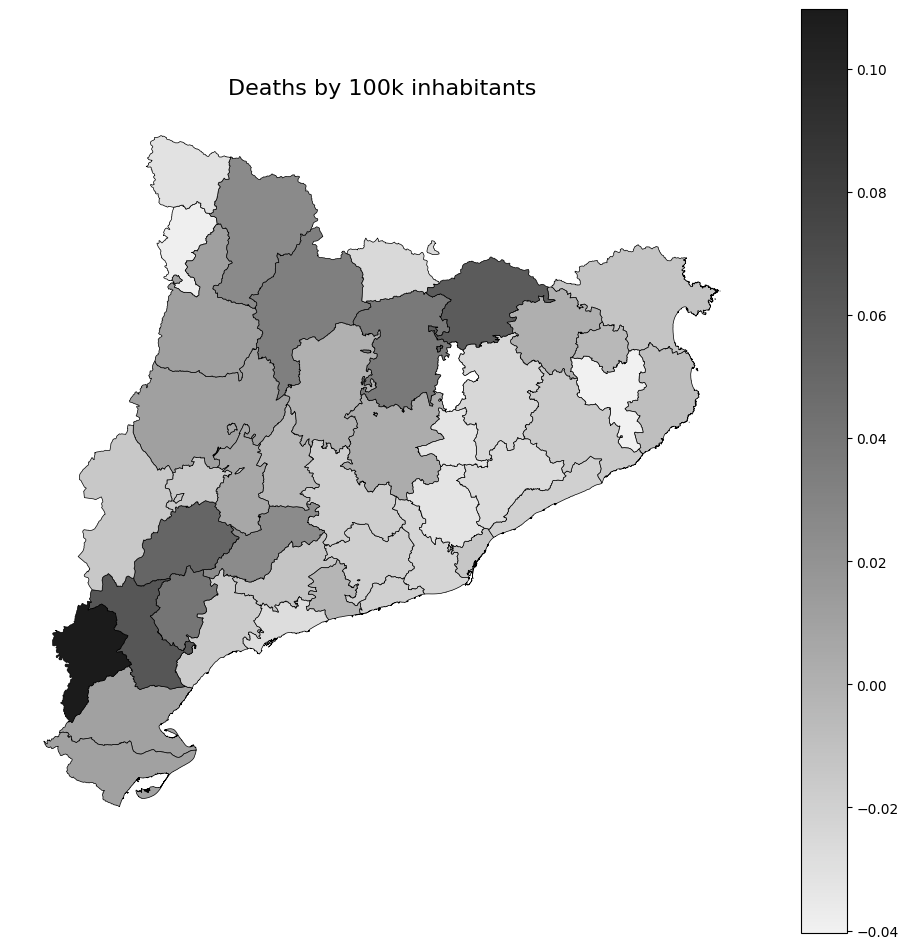

In [78]:
import colorcet as cc

df_plot = df_mort_com_men.copy()


zeros = df_plot['Total rel'] == 0.0
non_zeros = ~zeros
# Compute mean of non-zero values
mean = df_plot.loc[~zeros, 'Total rel'].mean()

# Center non-zero values
df_plot['Total rel centered'] = 0.0  # initialize
df_plot.loc[~zeros, 'Total rel centered'] = df_plot.loc[~zeros, 'Total rel'] - mean

# Normalize
norm_factor = df_plot['Total rel centered'].abs().sum()
df_plot['Total rel norm'] = 0.0
if norm_factor != 0.0:
    df_plot.loc[~zeros, 'Total rel norm'] = df_plot.loc[~zeros, 'Total rel centered'] / norm_factor


fig, ax = plt.subplots(figsize=(12, 12))

# Plot non-zero municipalities
df_plot[non_zeros].plot(
    column='Total rel norm',
    cmap=cc.cm["dimgray_r"],       # color map for positive values
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

# Plot zeros in grey on top
df_plot[zeros].plot(
    color='white',
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

ax.set_title('Deaths by 100k inhabitants', fontsize=16)
ax.axis('off')
plt.show()


In [79]:
for key, df in df_mort_com.items():

    # Convert columns to numeric
    df['num_defi']   = pd.to_numeric(df['num_defi'], errors='coerce').fillna(0)
    df['num_hospi']  = pd.to_numeric(df['num_hospi'], errors='coerce').fillna(0)
    df['pob']        = pd.to_numeric(df['pob'], errors='coerce').fillna(0)
    df['Total rel']  = pd.to_numeric(df['Total rel'], errors='coerce').fillna(0)

    # Compute coverage per 100k
    df['coverage_per_100k'] = np.where(
        df['pob'] > 0,
        (df['num_hospi'] + df['num_defi']) / df['pob'] * 100000,
        0
    )
    df_mort_com[key] = df

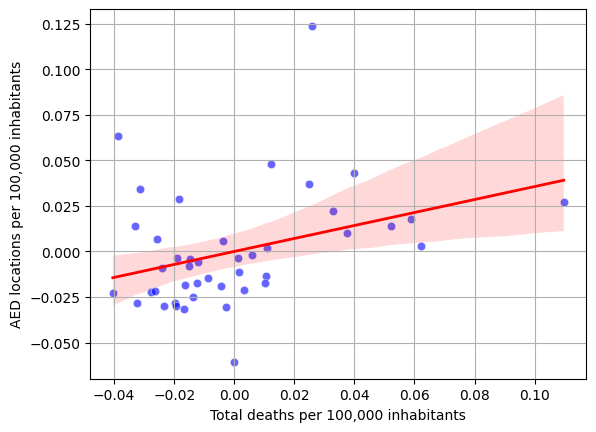

In [81]:
import seaborn as sns
name_plot = df_mort_com_total
# Scatter plot
# Scatter + linear trend with 95% confidence interval
"""
sns.regplot(
    data=name_plot,
    x='coverage_per_100k',
    y='Total rel',
    scatter=True,
    ci=95,          # confidence interval for the trend
    color='blue',
    line_kws={'color':'red', 'linewidth':2},
    scatter_kws={'alpha':0.7}
)
"""
#reg_data = name_plot[(10 < name_plot['coverage_per_100k']) & (700 > name_plot['coverage_per_100k'])]
 # or whichever dataframe contains coverage_per_100k

# Compute mean of coverage
mean_cov = df_plot['coverage_per_100k'].mean()

# Center
df_plot['coverage_centered'] = df_plot['coverage_per_100k'] - mean_cov

# Normalize by sum of absolute deviations
norm_factor_cov = np.abs(df_plot['coverage_centered']).sum()
df_plot['coverage_norm'] = 0.0
if norm_factor_cov != 0:
    df_plot['coverage_norm'] = df_plot['coverage_centered'] / norm_factor_cov


# Scatter with ALL data

sns.scatterplot(
    data=df_plot,
    y='coverage_norm',
    x='Total rel norm',
    alpha=0.6,
    color='blue'
)


# Regression ONLY on filtered data
sns.regplot(
    data=df_plot,
    y='coverage_norm',
    x='Total rel norm',
    scatter=False,      # do NOT plot points again
    ci=95,
    color='red',
    line_kws={'linewidth':2}
)
plt.ylabel('AED locations per 100,000 inhabitants')
plt.xlabel('Total deaths per 100,000 inhabitants')
#plt.title('Coverage vs Cardiovascular Deaths per Comarca with Trend and CI')
plt.grid(True)
plt.show()

In [69]:
from scipy.stats import linregress

name_reg = df_mort_com_total

name_reg = name_reg[(10 < name_reg['coverage_per_100k']) & (700 > name_plot['coverage_per_100k'])]

y = name_reg[['coverage_per_100k']].values
X = name_reg['Total rel'].values

res = linregress(
    y = name_plot['coverage_per_100k'],
    x = name_plot['Total rel']
)

print("Slope:", res.slope)
print("Intercept:", res.intercept)
print("R²:", res.rvalue**2)
print("p-value:", res.pvalue)
print("Std err:", res.stderr)

Slope: 0.2603550638180572
Intercept: 2.5323600911700908
R²: 0.22367097780110354
p-value: 0.0013615273589403047
Std err: 0.07575166684033247


In [73]:
df_mort_com_total.to_file("./Data/df_mort_com_total.gpkg", driver="GPKG")
df_mort_com_men.to_file("./Data/df_mort_com_men.gpkg", driver="GPKG")
df_mort_com_women.to_file("./Data/df_mort_com_women.gpkg", driver="GPKG")

comarques.to_file("./Data/comarques.gpkg", driver="GPKG")

comarca_totals.to_csv("./Data/comarca_totals.csv", index=False)